IUM Etap 2

Piotr Grabowski, Marcin Lusawa

Preprocesss data

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#load data
data_path = 'data2'
# csv_files = ['calendar', 'listings', 'reviews', 'sessions', 'users']
csv_files = ['reviews']

dataframes = {}

for file_name in csv_files:
    file_path = os.path.join(data_path, f'{file_name}.csv', f'{file_name}.csv')
    try:
        dataframes[file_name] = pd.read_csv(file_path)
        print(f"File {file_name}.csv  shape: {dataframes[file_name].shape}")
    except FileNotFoundError:
        print(f"File {file_path} not found")

reviews_df = dataframes.get('reviews')


File reviews.csv  shape: (1927665, 7)


In [ ]:
df = reviews_df[["listing_id", "comments", "date"]].copy()
df.head()

,listing_id,comments,date
0,2737,"This spot was in a great and nice area,walking...",2014-12-26
1,2737,"Elif was really very helpful, while arranging ...",2015-01-04
2,2737,"Elif's flat is spacious, clean, and had everyt...",2015-04-12
3,2737,I had a wonderful time staying with Elif and h...,2015-04-22
4,2737,"Elif was a brilliant host, with an exceptional...",2015-05-08


In [ ]:
df = df.dropna(subset=["listing_id", "comments"])

df["listing_id"] = df["listing_id"].astype("int64", errors="ignore")

df["date"] = pd.to_datetime(df["date"], errors="coerce")
print("Shape after basic cleaning:", df.shape)



Shape after basic cleaning: (1927547, 3)


In [5]:
df = df.drop_duplicates(subset=["listing_id", "comments"])
print("Shape after deduplication:", df.shape)


Shape after deduplication: (1926382, 3)


In [ ]:
df["len_chars"] = df["comments"].astype(str).str.len()

print("Mean length:", df["len_chars"].mean())
print("Median length:", df["len_chars"].median())

df = df[df["len_chars"] >= 20].copy()
print("Shape after length filter:", df.shape)


Mean length: 275.3892945428269
Median length: 209.0
Shape after length filter: (1861640, 4)


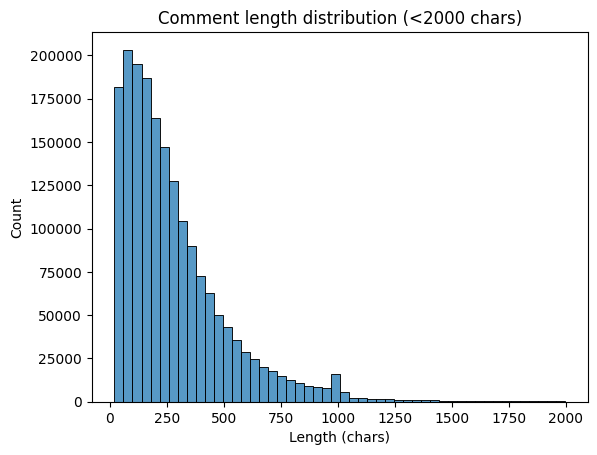

In [8]:
sns.histplot(df.loc[df["len_chars"] < 2000, "len_chars"], bins=50)
plt.title("Comment length distribution (<2000 chars)")
plt.xlabel("Length (chars)")
plt.show()


In [ ]:
import re

def clean_text_basic(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)  # linki
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_clean"] = df["comments"].apply(clean_text_basic)
df[["comments", "text_clean"]].head()


,comments,text_clean
0,"This spot was in a great and nice area,walking...","this spot was in a great and nice area,walking..."
1,"Elif was really very helpful, while arranging ...","elif was really very helpful, while arranging ..."
2,"Elif's flat is spacious, clean, and had everyt...","elif's flat is spacious, clean, and had everyt..."
3,I had a wonderful time staying with Elif and h...,i had a wonderful time staying with elif and h...
4,"Elif was a brilliant host, with an exceptional...","elif was a brilliant host, with an exceptional..."


In [ ]:
# N = 100_000
# df_s = df.sample(n=N, random_state=42).copy()
# df_s = df_s.reset_index(drop=True)
df_s = df.copy()
df_s.shape, df_s.head(2)


((1861640, 5),
    listing_id                                           comments       date  \
 0        2737  This spot was in a great and nice area,walking... 2014-12-26   
 1        2737  Elif was really very helpful, while arranging ... 2015-01-04   
 
    len_chars                                         text_clean  
 0        180  this spot was in a great and nice area,walking...  
 1        283  elif was really very helpful, while arranging ...  )

In [ ]:
import fasttext
from tqdm.auto import tqdm
import urllib.request
import os

tqdm.pandas()

model_path = "lid.176.bin"
if not os.path.exists(model_path):
    url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
    urllib.request.urlretrieve(url, model_path)
    print("Model downloaded!")

fasttext.FastText.eprint = lambda x: None
model = fasttext.load_model(model_path)

def detect_lang_fasttext(text, max_chars=600):
    try:
        text = str(text)[:max_chars].replace('\n', ' ')
        predictions = model.predict(text, k=1)
        lang_code = predictions[0][0].replace('__label__', '')
        return lang_code
    except:
        return "unknown"

print("Detecting languages with fastText")
df_s["lang"] = df_s["text_clean"].progress_apply(detect_lang_fasttext)
print("\nTop 15 detected languages:")
print(df_s["lang"].value_counts().head(15))


Detecting languages with fastText...


  0%|          | 0/1861640 [00:00<?, ?it/s]


Top 15 detected languages:
lang
en    1166207
it     172163
fr     168229
es     156417
de      58751
pt      33374
ko      17446
zh      14698
nl      14552
ru      13178
pl       8466
tr       6110
da       4515
sv       3670
el       2902
Name: count, dtype: int64


In [ ]:
os.makedirs("artifacts", exist_ok=True)
df_s.to_csv("artifacts/preprocessed_comments_all.csv", index=False)

print("Saved clean dataset:", df_s.shape)

# Filtr do top 10 języków
top_10_langs = df_s["lang"].value_counts().head(10).index.tolist()
print(f"\nKeeping only top 10 languages: {top_10_langs}")

df_s_top10 = df_s[df_s["lang"].isin(top_10_langs)].copy()
df_s_top10 = df_s_top10.reset_index(drop=True)

print(f"Shape after filtering to top 10 languages: {df_s_top10.shape}")
df_s_top10["lang"].value_counts()

Saved clean dataset: (1861640, 6)

Keeping only top 10 languages: ['en', 'it', 'fr', 'es', 'de', 'pt', 'ko', 'zh', 'nl', 'ru']
Shape after filtering to top 10 languages: (1815015, 6)


lang
en    1166207
it     172163
fr     168229
es     156417
de      58751
pt      33374
ko      17446
zh      14698
nl      14552
ru      13178
Name: count, dtype: int64

In [ ]:
os.makedirs("artifacts", exist_ok=True)
df_s_top10.to_csv("artifacts/preprocessed_comments_all_top10.csv", index=False)
print("Saved clean dataset:", df_s_top10.shape)

Saved clean dataset: (1815015, 6)


In [29]:
df_s.head()

,listing_id,comments,date,len_chars,text_clean,lang
0,2737,"This spot was in a great and nice area,walking...",2014-12-26,180,"this spot was in a great and nice area,walking...",en
1,2737,"Elif was really very helpful, while arranging ...",2015-01-04,283,"elif was really very helpful, while arranging ...",en
2,2737,"Elif's flat is spacious, clean, and had everyt...",2015-04-12,396,"elif's flat is spacious, clean, and had everyt...",en
3,2737,I had a wonderful time staying with Elif and h...,2015-04-22,358,i had a wonderful time staying with elif and h...,en
4,2737,"Elif was a brilliant host, with an exceptional...",2015-05-08,209,"elif was a brilliant host, with an exceptional...",en


In [ ]:
df_en = df_s[df_s["lang"] == "en"].copy()
df_en = df_en.reset_index(drop=True)
df_en.shape, df_en["lang"].value_counts().head()


((1166207, 6),
 lang
 en    1166207
 Name: count, dtype: int64)

In [ ]:
os.makedirs("artifacts", exist_ok=True)
df_en.to_csv("artifacts/preprocessed_comments_all_eng.csv", index=False)
print("Saved clean dataset:", df_en.shape)

Saved clean dataset: (1166207, 6)
